In [1]:
import gymnasium as gym
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

/home/jainam/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
class Agent():
    def __init__(self,render=0,q=[]):

        if(render==0):
            self.env = gym.make("MountainCar-v0")
        else:
            self.env = gym.make("MountainCar-v0", render_mode="human")
        self.env.reset()
        self.num_pos_states=5
        self.num_vel_states=5

        self.pos_range=[-1.2,0.6]
        self.vel_range=[-0.07,0.07]

        self.num_actions=self.env.action_space.n
        self.num_states=self.num_pos_states*self.num_vel_states
        if(len(q)==0):
            self.action_value=np.random.normal(size=(self.num_states, self.num_actions), loc=0.5, scale=0.001)
        else:
            self.action_value=q
        self.num_episodes=1000
        self.num_steps=100
        self.alpha=0.001
        self.gamma=0.9
        self.reward_array=[]
        self.epsilon=0.1


    def find_state(self, value, ranges, num_partitions):
        x=ranges[0]
        y=ranges[1]
        k=num_partitions
        inc=float(-x+y)/k
        for i in range(k):
            if value>=inc*i+x and value<inc*(i+1)+x:
                return i
            
        if value<x: return 0
        if value>=y: return k-1

    def find_final_state(self, value):
        pos_state=int(self.find_state(value[0], self.pos_range, self.num_pos_states))
        vel_state=int(self.find_state(value[1], self.vel_range, self.num_vel_states))

        return pos_state+self.num_pos_states*vel_state

            
    def epsilon_greedy(self,state):
        action_greedy=np.argmax(self.action_value[state])
        action_array=np.arange(self.num_actions)
        action_array=np.insert(action_array,0,action_greedy)
        prob_array=np.ones(self.num_actions)*self.epsilon/self.num_actions
        prob_array=np.insert(prob_array,0,1-self.epsilon)
        action_actual=np.random.choice(a=action_array, p=prob_array)
        return action_actual


    def episode_iter(self):
        curr_state=self.find_final_state(self.env.reset()[0])
        state_action_reward_array=[]
        cum_reward=0
        while(True):
            action=self.epsilon_greedy(curr_state)
            observation, reward, terminated, truncated, _=self.env.step(action)
            state_action_reward_array.append([curr_state, action, reward])
            curr_state=self.find_final_state(observation)
            cum_reward+=reward
            if(terminated or truncated):
                print(f'total reward is {cum_reward}')
                self.reward_array.append(cum_reward)
                return state_action_reward_array
            
    def SARSA_L(self):
        E=np.zeros((self.num_states, self.num_actions))
        for ne in range(self.num_episodes):
            raw_state=self.env.reset()[0]
            curr_state=self.find_final_state(raw_state)
            cum_reward=0
            action=self.epsilon_greedy(curr_state)
            for ns in range(self.num_steps):
                observation, reward, terminated, truncated, _=self.env.step(action)
                # print(reward)
                next_state=self.find_final_state(observation)
                next_action=self.epsilon_greedy(next_state)
                delta=reward+self.gamma*self.action_value[next_state,next_action]-self.action_value[curr_state,action]
                E[curr_state, action]+=1
                for s in range(self.num_states):
                    for a in range(self.num_actions):
                        self.action_value[s,a]+=self.alpha*delta*E[s,a]
                        E[s,a]=self.gamma*delta*E[s,a]
                curr_state=next_state
                action=next_action
                cum_reward+=reward
                # print(f'Car is in state {curr_state} at step {ns} of episode {ne}')
                if terminated or truncated: 
                    print("hi")
                    self.reward_array.append(cum_reward)
                    print(cum_reward)
                    break

    def TD0(self):
        for ne in range(self.num_episodes):
            curr_state=self.find_final_state(self.env.reset()[0])
            cum_reward=0
            action=self.epsilon_greedy(curr_state)
            for ns in range(self.num_steps):
                observation, reward, terminated, truncated, _=self.env.step(action)
                # print(reward)
                next_state=self.find_final_state(observation)
                next_action=self.epsilon_greedy(next_state)
                self.action_value[curr_state,action]+=self.alpha*(reward+self.gamma*self.action_value[next_state,next_action]-self.action_value[curr_state,action])
                curr_state=next_state
                action=next_action
                cum_reward+=reward
                # print(f'Car is in state {next_state} at step {ns} of episode {ne}')
                if terminated or truncated: 
                    print("hi")
                    self.reward_array.append(cum_reward)
                    break

    
    def MonteCarlo(self):
        for _ in range(self.num_episodes):

            reward_array=self.episode_iter()
            n=len(reward_array)
            Gt=np.zeros(n)
            Gt[n-1]=reward_array[n-1][2]
            for i in range(n-2,-1,-1):
                Gt[i]=reward_array[i][2]+self.gamma*Gt[i+1]

            for i,(state,action,_) in enumerate(reward_array):
                self.action_value[state,action]+=self.alpha*(Gt[i]-self.action_value[state,action])


    def graph_plotter(self):
        time=np.arange(len(self.reward_array))
        plt.plot(time,self.reward_array)
        plt.show()
        


In [3]:
class Deterministic_Agent():
    def __init__(self, render=0, q=[]):
        if(render==0):
            self.env = gym.make("MountainCar-v0")
        else:
            self.env = gym.make("MountainCar-v0", render_mode="human")
        self.env.reset()

        self.num_pos_states=5
        self.num_vel_states=5

        self.pos_range=[-1.2,0.6]
        self.vel_range=[-0.07,0.07]

        self.num_actions=self.env.action_space.n
        self.num_states=self.num_pos_states*self.num_vel_states
        if(len(q)==0):
            self.state_value=np.random.normal(size=self.num_states, loc=0.5, scale=0.001)
        else:
            self.state_value=q

    def find_state(self, value, ranges, num_partitions):
        x=ranges[0]
        y=ranges[1]
        k=num_partitions
        inc=float(-x+y)/k
        for i in range(k):
            if value>=inc*i+x and value<inc*(i+1)+x:
                return i
            
        if value<x: return 0
        if value>=y: return k-1

    def find_final_state(self, value):
        pos_state=int(self.find_state(value[0], self.pos_range, self.num_pos_states))
        vel_state=int(self.find_state(value[1], self.vel_range, self.num_vel_states))

        return pos_state+self.num_pos_states*vel_state
    
    def greedy(self, curr_state):
        pass

    def episode_iter(self):
        curr_state=self.find_final_state(self.env.reset()[0])
        cum_reward=0
        while(True):
            action=self.greedy(curr_state)
            observation, reward, terminated, truncated, _=self.env.step(action)
            curr_state=self.find_final_state(observation)
            cum_reward+=reward
            if(terminated or truncated):
                self.reward_array.append(cum_reward)
                return

    def Value_Iteration(self):
        for action in range(self.num_actions):
            observation, reward, terminated, truncated, _=self.env.step(action)
            next_state=self.find_final_state(observation)
            cost=reward+self.state_value[next_state]
            if cost>max_cost:
                max_cost=cost

    def graph_plotter(self):
        time=np.arange(len(self.reward_array))
        plt.plot(time,self.reward_array)
        plt.show()

/tmp/ipykernel_6126/2850444683.py:89: RuntimeWarning: overflow encountered in double_scalars
  self.action_value[s,a]+=self.alpha*delta*E[s,a]
/tmp/ipykernel_6126/2850444683.py:90: RuntimeWarning: overflow encountered in double_scalars
  E[s,a]=self.gamma*delta*E[s,a]
/tmp/ipykernel_6126/2850444683.py:85: RuntimeWarning: invalid value encountered in double_scalars
  delta=reward+self.gamma*self.action_value[next_state,next_action]-self.action_value[curr_state,action]


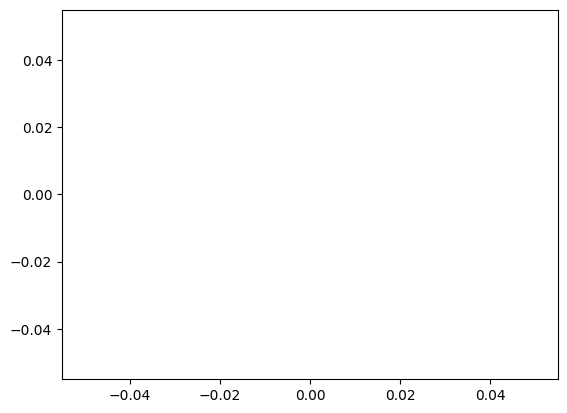

In [7]:
agent1=Agent(render=0)
agent1.SARSA_L()
agent1.env.close()
agent1.graph_plotter()

In [5]:
print(agent1.action_value)

[[ 0.49196078  0.486134    0.49826975]
 [ 0.2769896   0.30677853  0.3122845 ]
 [ 0.40717175  0.39376757  0.35892286]
 [ 0.50043682  0.49926343  0.50066649]
 [ 0.49987484  0.49898563  0.50002079]
 [-0.06806306 -0.07307773 -0.07064828]
 [-5.57672949 -5.45852981 -5.4299597 ]
 [-2.57829286 -2.57277929 -2.59645555]
 [ 0.26961093  0.27396188  0.27576461]
 [ 0.50010851  0.49828987  0.49854303]
 [-1.52455427 -1.2099007  -1.31863678]
 [-9.62886284 -9.46783461 -9.60102222]
 [-9.61631128 -9.6587492  -9.62801618]
 [-0.45384616 -0.40048653 -0.40071304]
 [ 0.490659    0.3732173   0.49931218]
 [ 0.15015208  0.19863158  0.17380118]
 [-5.12188204 -4.94561191 -4.99808776]
 [-3.44950206 -3.47472819 -3.43005897]
 [ 0.14309452  0.13822489  0.07994083]
 [ 0.49851809  0.48979374  0.48025766]
 [ 0.49958296  0.49985139  0.49960988]
 [ 0.36525174  0.41629233  0.37754547]
 [ 0.417602    0.39531273  0.37371523]
 [ 0.50071053  0.50055924  0.49927281]
 [ 0.49792078  0.50036432  0.49998659]]


In [6]:
agent2=Agent(render=1, q=agent1.action_value)
agent2.episode_iter()

total reward is -200.0


[[12, 0, -1.0],
 [11, 0, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 2, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 2, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 0, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 0, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1, -1.0],
 [11, 1,